<h1><center>Applied Data Science Capstone Project - The Battle of Neighbourhoods</center></h1>

#### Table of Contents
* [Introduction](#introduction)
* [Data](#data)
* [Methodology](#methodology)
    * [Analysis](#analysis)
* [Results (including Insights & Discussion)](#results)
* [Conclusion](#conclusion)

---

In addition to any breakdowns given within this Notebook, more complete sections will be included in the project report.

## Introduction <a name="introduction"></a>

### Background

When deciding on a location to set up a business there are several essential aspects of the area that need to be considered:
* Security and safety (business operations and public grounds)
* Marketing and promotional opportunities
* Business specific concerns - organized capital improvements and planning

In the city of Toronto there are resources available to small business owners and entrepreneurs to establish a setting in which businesses can operate in a safe and competitive environment. A primary example of such a resource is **Toronto's BIA program**. A *BIA* - *Business Improvement Area* - is an association of commercial property owners and tenants that work together in a partnership, defined in a given area, with the city of Toronto to create an atmosphere in which business can be conducted safely and competitively in such a way that attracts customers and new businesses. BIAs in many ways are the catalysts for the improvements that create the kinds of strong communities that allow new businesses to integrate into and contribute to Toronto's economy.

### Business Problem

Despite the opportunities and resources afforded to new businesses, there are difficulties that face entrepreneurs and business owners looking to grow their operation in one of Toronto's neighbourhoods. Depending on the nature of the business it may be challenging to secure enough capital towards efforts to gather extensive information on competitors and BIA initiatives separately. 

This project aims to provide a tool in which new business owners can *evaluate the level of competition in each Toronto neighbourhood and cross-reference these locations against established BIAs.* Businesses will be able to **evaluate locations on the basis of competition density and enhancement via the Business Improvement Areas**.

## Data <a name="data"></a>

In order to determine the viability of a particular area a combination of **Foursquare location data** and the **Toronto BIA open dataset** will be utilized.

### Foursquare Data

To explore venues in particular areas via the Foursquare API, the following sources will be used to generate and shape the data to perform further analysis:
* Geospatial coordinates read from an external dataset via http://cocl.us/Geospatial_data
* Toronto postal codes, boroughs and neighbourhoods data web scraped from https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

`Latitude, Longitude` values for each neighbourhood will provide the basis for the API calls and venue exploration.

The Foursquare API will be used primarily to retrieve area venue categories within a predefined `RADIUS`. The data will be analyzed for the most frequent venue categories and compared to the target business category to serve as **"competition level/density"**, one component of the overall area evaluation metric.

### Toronto BIA Data

The second component of the metric would incorporate the location data provided for each Toronto BIA. The dataset provides `Latitude, Longitude` geometries of the BIAs with central coordinates and identifiers (e.g. `AREA_NAME`). The distance to each BIA's center will be determined relative to each neighbourhood and the BIA will be considered based on the `RADIUS` as specified for the initial Foursquare venue exploration. 

## Methodology <a name="methodology"></a>

We'll begin by importing the packages necessary to construct the dataframes (`pandas`) and web scrape the Toronto neighbourhood information (`requests`, `BeautifulSoup` and `lxml` - html parser).

In [2]:
import pandas as pd
import requests

!pip install beautifulsoup4
from bs4 import BeautifulSoup
!pip install lxml
from lxml import html

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

     |████████████████████████████████| 112kB 7.1MB/s eta 0:00:01
     |████████████████████████████████| 5.8MB 7.4MB/s eta 0:00:01


### Web Scraping Initial Neighbourhoods Data

Following that we'll setup the base dataframe structure and scrape the Wikipedia information. The web scraping involves iterating through the table's rows and testing for certain conditions (ensuring a baseline for the data values):
* Testing for and ignoring 'Not assigned' entries
* If a particular postal code has been encountered before (based on a list updated each iteration), then concatenating neighbourhoods under the same code as necessary

In [3]:
column_names = ['PostalCode', 'Borough', 'Neighbourhood']
neighbourhoods = pd.DataFrame(columns = column_names)

source = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(source, 'html.parser')
table = soup.find('table')
table_body = table.find('tbody')
rows = table_body.find_all('tr')

postal_codes = []

#Skipping the first row of columns headers with rows[1:]
for row in rows[1:]:
    cols = row.find_all('td')
    #cols[0] -> PostalCode, cols[1] -> Borough, cols[2] -> Neighbourhood
    #Condition 1 check
    if (cols[1].text.strip() == 'Not assigned'):
        continue
    elif (cols[2].text.strip() == 'Not assigned'):
        cols[2] = cols[1]
    #Condition 2 check
    if (cols[0].text.strip() in postal_codes):
        i = postal_codes.index(cols[0].text.strip())
        neighbourhoods.iloc[i]['Neighbourhood'] = neighbourhoods.iloc[i]['Neighbourhood'] + ', ' + cols[2].text.strip()
    else:
        postal_codes.append(cols[0].text.strip())
        data = {
            'PostalCode': cols[0].text.strip(),
            'Borough': cols[1].text.strip(),
            'Neighbourhood': cols[2].text.strip()
        }
        neighbourhoods = neighbourhoods.append(data, ignore_index = True)

neighbourhoods.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,Harbourfront
3,M6A,North York,"Lawrence Heights, Lawrence Manor"
4,M7A,Downtown Toronto,Queen's Park


### Retrieving & Merging Postal Code Latitude, Longitude Matches

Based on the organization of the neighbourhoods using postal codes, geospatial coordinate data (via the `geospatial_coordinates.csv`) will be retrieved and merged with information on neighbourhoods within the dataset.

According to the structure of the csv file data we can merge the to be created `geo_df` dataframe with the existing `neighbourhoods` dataframe on the **`'PostalCode'/'Postal Code'`** column. The redundant `'Postal Code'` column is then dropped after the merge.

<span style="color:red">Due to issues with the http://cocl.us/Geospatial_data link and subsequent file download, a copy of the dataset has been included in the notebook file location to avoid errors parsing the corrupt downloaded version.</span>

In [122]:
#!wget -q -O 'geospatial_coordinates.csv' http://cocl.us/Geospatial_data
#print('Download complete') -> Download stopped working

geo_df = pd.read_csv("geospatial_coordinates.csv")

neighbourhoods_geo = pd.merge(neighbourhoods, geo_df, left_on = 'PostalCode', right_on = 'Postal Code')
neighbourhoods_geo.drop(columns = ['Postal Code'], inplace = True)
neighbourhoods_geo.sort_values('Neighbourhood', inplace = True)
neighbourhoods_geo.reset_index(drop = True, inplace = True)

neighbourhoods_geo.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M5H,Downtown Toronto,"Adelaide, King, Richmond",43.650571,-79.384568
1,M1S,Scarborough,Agincourt,43.794200,-79.262029
2,M1V,Scarborough,"Agincourt North, L'Amoreaux East, Milliken, St...",43.815252,-79.284577
3,M9V,Etobicoke,"Albion Gardens, Beaumond Heights, Humbergate, ...",43.739416,-79.588437
4,M8W,Etobicoke,"Alderwood, Long Branch",43.602414,-79.543484


### **Foursquare API** - Setup & Venue Exploration

The following cell imports the `geocoders` and `folium` packages for map generation (`geocoders Nominatim` is used to determine the latitude, longitude coordinates for Toronto). 

In [8]:
!pip install geopy
from geopy.geocoders import Nominatim
!pip install 'folium==0.5.0'
import folium

     |████████████████████████████████| 112kB 26.8MB/s eta 0:00:01


Credentials and parameters for the Foursquare API are established for the venue exploration call.

In [9]:
CLIENT_ID = 'RQMFZC0BRLLSPC2VXSDH2E45WUYJLE5FMWKUYPTHFIR0FRV3'
CLIENT_SECRET = 'PKCLP2UXF4IHAAOUKMUV02IUJADO3W55JT3JXVGC1ZORDFM5'
VERSION = '20180605'
LIMIT = 100
RADIUS = 750

#Determining map center-point (Toronto latitude, longitude)
address = 'Toronto, ON'
geolocator = Nominatim(user_agent = "foursquare_agent")
city_location = geolocator.geocode(address)
city_lat = city_location.latitude
city_lng = city_location.longitude
print('The geographical coordinates of the city of Toronto are {}, {}'.format(city_lat, city_lng))

The geographical coordinates of the city of Toronto are 43.653963, -79.387207


Next, we'll create a `getNearbyVenues(...)` function to follow through with the Foursquare API call and add its results to a dataframe of `'nearby_venues'` for a particular neighbourhood. Only the **`Venue`** and **`Venue Category`** data is pertinent to our analysis later on.

In [10]:
def getNearbyVenues(names, latitudes, longitudes):
    
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            RADIUS, 
            LIMIT)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            name,
            v['venue']['name'],
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 'Venue', 'Venue Category']
    
    return(nearby_venues)

Now using the `neighbourhoods_geo` dataframe created prior we can run the method to get nearby venues based on each neighbourhoods latitude, longitude coordinates.

In [11]:
toronto_venues = getNearbyVenues(neighbourhoods_geo['Neighbourhood'], neighbourhoods_geo['Latitude'], neighbourhoods_geo['Longitude'])
toronto_venues.head(10)

,Neighbourhood,Venue,Venue Category
0,"Adelaide, King, Richmond",Four Seasons Centre for the Performing Arts,Concert Hall
1,"Adelaide, King, Richmond",The Keg Steakhouse + Bar,Steakhouse
2,"Adelaide, King, Richmond",Nathan Phillips Square,Plaza
3,"Adelaide, King, Richmond",Rosalinda,Vegetarian / Vegan Restaurant
4,"Adelaide, King, Richmond",Shangri-La Toronto,Hotel
5,"Adelaide, King, Richmond",Soho House Toronto,Speakeasy
6,"Adelaide, King, Richmond",Hy's Steakhouse,Steakhouse
7,"Adelaide, King, Richmond",Cafe Landwer,Café
8,"Adelaide, King, Richmond",Noodle King,Asian Restaurant
9,"Adelaide, King, Richmond",Downtown Toronto,Neighborhood


Based on the data we have for each neighbourhood and the corresponding venue categories, `toronto_encoded` is the categorical venue data converted to *indicator* variables that can be aggregated later on to show the number of a particular venue in a given neighbourhood.

Since `toronto_venues` is the dataframe being converted, the `Neighbourhood` column is dropped and inserted into the correct position and the beginning of the dataframe.

In [12]:
toronto_encoded = pd.get_dummies(toronto_venues[['Venue Category']], prefix = "", prefix_sep = "")
toronto_encoded.drop(columns = ['Neighborhood'], inplace = True)
toronto_encoded.insert(0, 'Neighbourhood', toronto_venues['Neighbourhood'])

toronto_encoded.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Aquarium,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bike Rental / Bike Share,Bike Shop,Bistro,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Castle,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Churrascaria,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Curling Ice,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Festival,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indonesian Restaurant,Indoor Play Area,Intersection,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kids Store,Korean Restaurant,Lake,Latin American Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Motorcycle Shop,Movie Theater,Museum,Music School,Music Store,Music Venue,Nail Salon,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Outdoor Supply Store,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Performing Arts Venue,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Shopping Plaza,Skate Park,Skating Rink,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,Social Club,Soup Place,Southern / So

### Determining the Most Frequent Venue per Neighbourhood

In the following cells `toronto_grouped` is a summation aggregation of the `toronto_encoded` data. The `neighbourhoods_venues_sorted` dataframe contains listings of neighbourhoods' top **n** venue categories to the number of occurrences of that venue type.

The methods `return_most_common_venues(...)` and `return_most_common_venues_vals(...)` are used to return the top `num_top_venues` (essentially **n**) venue categories for a given `row` neighbourhood. 

#### Choosing **n** ...

As shown in `neighbourhoods_venues_sorted` **n** was chosen to be *5* to account for the majority of neighbourhoods having relative sparsity in regards to venue categories. There are many situations in that neighbourhoods have individual sites for specific venue categories with a minimal amount of venue types occurring multiple times. Selecting, albeit relatively arbitrarily, *n = 5* ensures that the represented venue categories are highly relevant to the overall neighbourhood's competition structure while separating from instances where '*noise*' exists (i.e. many venue categories with singular occurrences).

In [13]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

def return_most_common_venues_vals(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.values[0:num_top_venues]

In [14]:
toronto_grouped = toronto_encoded.groupby('Neighbourhood').sum().reset_index()

n = 5

#For column header formatting e.g. 1st, 2nd, 3rd, ...
indicators = ['st', 'nd', 'rd']

columns = ['Neighbourhood']
for ind in range(n):
    try:
        columns.append('{}{} Most Common Venue'.format(ind + 1, indicators[ind]))
        columns.append('# of {}{} Venue'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind + 1))
        columns.append('# of {}th Venue'.format(ind + 1))
    
neighbourhoods_venues_sorted = pd.DataFrame(columns = columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in range(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1::2] = return_most_common_venues(toronto_grouped.iloc[ind, :], n)
    neighbourhoods_venues_sorted.iloc[ind, 2::2] = return_most_common_venues_vals(toronto_grouped.iloc[ind, :], n)
    
neighbourhoods_venues_sorted.head(10)

,Neighbourhood,1st Most Common Venue,# of 1st Venue,2nd Most Common Venue,# of 2nd Venue,3rd Most Common Venue,# of 3rd Venue,4th Most Common Venue,# of 4th Venue,5th Most Common Venue,# of 5th Venue
0,"Adelaide, King, Richmond",Coffee Shop,8,Café,6,Steakhouse,4,Thai Restaurant,3,Cosmetics Shop,3
1,Agincourt,Supermarket,1,Skating Rink,1,Mediterranean Restaurant,1,Seafood Restaurant,1,Shanghai Restaurant,1
2,"Agincourt North, L'Amoreaux East, Milliken, St...",Chinese Restaurant,3,Fast Food Restaurant,2,Pizza Place,2,Coffee Shop,1,Malay Restaurant,1
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",Grocery Store,3,Pizza Place,2,Hardware Store,1,Auto Garage,1,Coffee Shop,1
4,"Alderwood, Long Branch",Convenience Store,2,Pizza Place,2,Pool,1,Donut Shop,1,Sandwich Place,1
5,"Bathurst Manor, Downsview North, Wilson Heights",Coffee Shop,2,Pizza Place,2,Gas Station,1,Community Center,1,Sandwich Place,1
6,Bayview Village,Japanese Restaurant,2,Bank,2,Café,1,Shopping Mall,1,Grocery Store,1
7,"Bedford Park, Lawrence Manor East",Coffee Shop,3,Italian Restaurant,3,Sandwich Place,2,Fast Food Restaurant,2,Breakfast Spot,1
8,Berczy Park,Coffee Shop,9,Café,5,Beer Bar,4,Restaurant,4,Hotel,4
9,"Birch Cliff, Cliffside West",Construction & Landscaping,1,Thai Restaurant,1,College Stadium,1,Diner,1,Café,1


### Toronto BIA Data

The **Toronto BIA data** is available via https://open.toronto.ca/dataset/business-improvement-areas/. Along with the data in various formats (**GeoJSON** will be explored to visualize the areas), the resource also provides developer snippets to access the data.

From the available BIA data the `bia_data` dataframe retains the `AREA_ID`, `AREA_NAME`, `LATITUDE` and `LONGITUDE` fields to identify the BIAs and later on for distance calculation for each neighbourhood to assess BIA availability to a particular community. The `bia_geo_data` contains the area geometry information for BIA map visualization.

In [15]:
import urllib
import json

url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/package_show"
params = {"id": "9edb9628-1213-42bd-8352-5c4ed28e9e42"}
response = urllib.request.urlopen(url, data = bytes(json.dumps(params), encoding = "utf-8"))
package = json.loads(response.read())

for idx, resource in enumerate(package["result"]["resources"]):
    if resource["datastore_active"]:
        url = "https://ckan0.cf.opendata.inter.prod-toronto.ca/api/3/action/datastore_search"
        p = {"id": resource["id"]}
        r = urllib.request.urlopen(url, data = bytes(json.dumps(p), encoding = "utf-8"))
        data = json.loads(r.read())
        bia_data = pd.DataFrame(data["result"]["records"])
        break
        
bia_geo_data = bia_data[['geometry']]
bia_data = bia_data[['AREA_ID', 'AREA_NAME', 'LATITUDE', 'LONGITUDE']]
bia_data.head()

,AREA_ID,AREA_NAME,LATITUDE,LONGITUDE
0,2481875,Rogers Road,43.681791,-79.469890
1,2481874,Bloor-Yorkville,43.670401,-79.389159
2,2481873,Little Italy,43.655397,-79.414394
3,2481872,Liberty Village,43.637670,-79.421265
4,2481871,Leslieville,43.662460,-79.333555


### Toronto Neighbourhood & BIA Location Visualization

To get an idea of the orientation of the neighbourhoods relative to the BIAs in the city of Toronto we can use `Folium` to display the BIA geometries from `bia_geo_data` with the location points for each neighbourhood superimposed on the same map. 

Based on the resulting map its apparent that neighbourhoods located closer to the core of the city will have a higher availability of BIA resources and opportunities. 

In [16]:
toronto_bia_geo = bia_geo_data['geometry']

toronto_map = folium.Map(location = [city_lat, city_lng], zoom_start = 11)

bia_locations = folium.map.FeatureGroup()

for geometry in toronto_bia_geo:
    bia_locations.add_child(
        folium.features.GeoJson(geometry)
    )

toronto_map.add_child(bia_locations)   
    
for lat, lng, nhood in zip(neighbourhoods_geo['Latitude'], neighbourhoods_geo['Longitude'], neighbourhoods_geo['Neighbourhood']):
    label = '{}'.format(nhood)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7
    ).add_to(toronto_map)

toronto_map

### Determining the **BIA Availability** for each Neighbourhood

In order to determine the **BIA Availability** for each neighbourhood, we need to calculate the distance of each BIA (using the `[LATITUDE, LONGITUDE]` coordinates from `bia_data`) to each neighbourhood location point (using the corresponding `[Latitude, Longitude]` data from `neighbourhoods_geo`). 

Distance calculation will be done using `geopy`'s `geodesic` distance function. The **geodesic method** is accurate to round-off and always converges; it calculates the distance as the shortest distance on the surface of an ellipsoidal model of the Earth. The default ellipsoid model of **WGS-84** will be used for the calculation, this method is accepted as the most globally accurate.

---

To explain the main components of the computation, `bia_counts` is used to store the number of BIAs available to a particular neighbourhood whereas `bia_dists` stores whether the distance to each BIA from a particular neighbourhood is within the `RADIUS` as specified during the Foursquare venue exploration (*note* - `RADIUS` is divided by 1000 as the measure is in meters). For each neighbourhood iteration the `bia_counts` `numpy` array is updated with the total count of BIAs within range. From there the `bia_dists` array is reset for the next neighbourhood iteration.

The `neighbourhoods_bia` dataframe is then constructed following the computation to store the elements necessary for analysis later on. We will go on to include the counts for the particular venue category for competition density in addition to `Available BIAs`.

In [91]:
from geopy import distance
import numpy as np

bia_counts = np.zeros(neighbourhoods_geo.shape[0])
bia_dists = np.zeros(bia_data.shape[0])

for n_idx, (lat, lng) in enumerate(zip(neighbourhoods_geo['Latitude'], neighbourhoods_geo['Longitude'])):
    nhood_coords = (lat, lng)
    for b_idx, (bia_lat, bia_lng) in enumerate(zip(bia_data['LATITUDE'], bia_data['LONGITUDE'])):
        bia_coords = (bia_lat, bia_lng)
        g_dist = distance.geodesic(nhood_coords, bia_coords, ellipsoid = 'WGS-84').km
        bia_dists[b_idx] = g_dist < (RADIUS / 1000)
    bia_counts[n_idx] = np.count_nonzero(bia_dists)
    bia_dists = np.zeros(bia_data.shape[0])

#Constructing the neighbourhoods_bia dataframe for use in ML analysis
columns = ['Neighbourhood', 'Available BIAs']
neighbourhoods_bia = pd.DataFrame(columns = columns)

neighbourhoods_bia['Neighbourhood'] = neighbourhoods_geo.loc[:, 'Neighbourhood']
#neighbourhoods_bia['Latitude'] = neighbourhoods_geo.loc[:, 'Latitude']
#neighbourhoods_bia['Longitude'] = neighbourhoods_geo.loc[:, 'Longitude']

neighbourhoods_bia['Available BIAs'] = bia_counts.astype(int)
neighbourhoods_bia.drop([68,75,93], axis = 0, inplace = True)
neighbourhoods_bia.reset_index(drop = True, inplace = True)

neighbourhoods_bia.head(10)

,Neighbourhood,Available BIAs
0,"Adelaide, King, Richmond",2
1,Agincourt,1
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0
4,"Alderwood, Long Branch",0
5,"Bathurst Manor, Downsview North, Wilson Heights",0
6,Bayview Village,0
7,"Bedford Park, Lawrence Manor East",0
8,Berczy Park,2
9,"Birch Cliff, Cliffside West",0


### Selecting a **Target Business Category**

Before we proceed we need to select a **target business category/categories** to focus on to generate features for the analysis. 

For our particular analysis we'll focus on a prospective entrepreneur looking to open a **coffee-related** business in the city of Toronto. Based on the possible Foursquare venues, the categories that fit that particular domain are **"Coffee Shop"** and **"Café"** (we're assuming the venture involves starting a generic coffee-related business, therefore we'll ignore ethnic and specialty shop categories). 

We'll now incorporate the frequent venue categories data from `neighbourhoods_venues_sorted` into `neighbourhoods_bia`.

In [92]:
coffee_shop_count = np.zeros(neighbourhoods_bia.shape[0])
cafe_count = np.zeros(neighbourhoods_bia.shape[0])

#Top_venues -> columns of neighbourhoods_venues_sorted that store the category
#Top_counts -> columns of neighbourhoods_venues_sorted that store the corresponding counts for each type
top_venues = neighbourhoods_venues_sorted.iloc[:, 1::2]
top_counts = neighbourhoods_venues_sorted.iloc[:, 2::2]

for venue_col, count_col in zip(top_venues, top_counts):
    for idx, nhood in enumerate(neighbourhoods_bia['Neighbourhood']):
        if (top_venues.loc[idx, venue_col] == 'Coffee Shop'):
            coffee_shop_count[idx] += top_counts.loc[idx, count_col]
        elif (top_venues.loc[idx, venue_col] == 'Café'):
            cafe_count[idx] += top_counts.loc[idx, count_col]
            
neighbourhoods_bia['Coffee Shops'] = coffee_shop_count.astype(int)
neighbourhoods_bia['Cafés'] = cafe_count.astype(int)

neighbourhoods_bia.head(15)

,Neighbourhood,Available BIAs,Coffee Shops,Cafés
0,"Adelaide, King, Richmond",2,8,6
1,Agincourt,1,0,0
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0,1,0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0,1,0
4,"Alderwood, Long Branch",0,0,0
5,"Bathurst Manor, Downsview North, Wilson Heights",0,2,0
6,Bayview Village,0,0,1
7,"Bedford Park, Lawrence Manor East",0,3,0
8,Berczy Park,2,9,5
9,"Birch Cliff, Cliffside West",0,0,1


Now that we've established a basis for the data features we need, we can proceed with the machine learning analysis.

### **Analysis** - K-Means Clustering <a name="analysis"></a>

For this project we'll be performing **K-Means** clustering on the data as the primary focus of the analysis. K-Means is a used in many data science applications and, in our particular case, will provide the opportunity to discover useful insights from the relevant data in a scenario that requires an unsupervised learning technique. One of the real-world applications of K-Means is *customer segmentation*, a problem domain with characteristics similar to that of our business problem. Furthermore, K-Means fits our application as the project involves *"neighbourhood segmentation"*, requiring knowledge of neighbourhood BIA availability and competition density. In addition, K-Means is efficient on the scale of dataset size that we're utilizing (not large enough to start to hinder performance).



We'll begin the analysis by importing `KMeans` from the `sklearn.cluster` package. **k = 5** was chosen based on observational evaluation of the degree of difference between the resulting clusters. It is important to avoid any scenario in which clusters are formed on the basis of a unit case (i.e. all clusters should have multiple members with similar characteristics to ensure insights can be obtained from the segmentation).

#### Preprocessing

Using `StandardScaler` from the `sklearn.preprocessing` package we're able to standardize the data features by removing the mean and scaling to unit variance. This step is essential to ensure that no discrepancies in the analysis occur due to the scaling difference between the *BIA Availability* and *Competition Density* factors.

In [93]:
from sklearn.preprocessing import StandardScaler
X = neighbourhoods_bia.values[:, 1:]
cluster_data = StandardScaler().fit_transform(X)
cluster_data[0:5]

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[ 1.80867813,  1.37267437,  1.99851533],
       [ 0.54386825, -0.73507898, -0.58577173],
       [-0.72094163, -0.47160981, -0.58577173],
       [-0.72094163, -0.47160981, -0.58577173],
       [-0.72094163, -0.73507898, -0.58577173]])

`cluster_data` uses the relevant columns of `neighbourhoods_bia` (now scaled using `StandardScaler`) to perform the K-Means clustering.

In [94]:
from sklearn.cluster import KMeans

k = 5

k_means = KMeans(init = 'k-means++', n_clusters = k, n_init = 20).fit(cluster_data)

labels = k_means.labels_
labels[0:10]

array([3, 4, 0, 0, 0, 0, 0, 0, 3, 0], dtype=int32)

A `'Competition Density'` column is added to `neighbourhoods_bia` along with the cluster labels for better examination of how each individual neighbourhood fits into a cluster.

In [95]:
neighbourhoods_bia['Competition Density'] = neighbourhoods_bia['Coffee Shops'] + neighbourhoods_bia['Cafés']
neighbourhoods_bia['Cluster'] = labels
neighbourhoods_bia.head(10)

,Neighbourhood,Available BIAs,Coffee Shops,Cafés,Competition Density,Cluster
0,"Adelaide, King, Richmond",2,8,6,14,3
1,Agincourt,1,0,0,0,4
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0,1,0,1,0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0,1,0,1,0
4,"Alderwood, Long Branch",0,0,0,0,0
5,"Bathurst Manor, Downsview North, Wilson Heights",0,2,0,2,0
6,Bayview Village,0,0,1,1,0
7,"Bedford Park, Lawrence Manor East",0,3,0,3,0
8,Berczy Park,2,9,5,14,3
9,"Birch Cliff, Cliffside West",0,0,1,1,0


`nb_factors` is a dataframe created to store the key summarizing factors associated with determining the viability of a particular neighbourhood. A third measure of `'BIA/Comp Ratio'` evaluates the ratio of available BIAs to competitors in the range of the neighbourhood, this measure is used as a high-level comparator between the different clusters to differentiate the level of viability as a new business location.

To avoid `inf` calculations based on areas with no competitors and 1 BIA, for the sake of this particular diagnostic all neighbourhoods with 0 competitors were handled with a ratio equal to that of the available BIAs. This ensures that areas with low competition counts (Competition Density = 0) are represented in the ratio calculations.

In [110]:
nb_factors = neighbourhoods_bia.loc[:, ['Neighbourhood', 'Available BIAs', 'Competition Density']]

ratios = np.zeros(nb_factors.shape[0])

for idx, (bia, comp) in enumerate(zip(nb_factors['Available BIAs'], nb_factors['Competition Density'])):
    if (comp == 0):
        ratios[idx] = bia
    else:
        ratios[idx] = bia / comp
        
nb_factors['BIA/Comp Ratio'] = ratios

#### Cluster Scatter Plot Visualization

The following uses `matplotlib`'s `pyplot` to show a simplistic view of the clusters as represented by the relationship between **BIA Availability** and **Competition Density**. The radius of the markers is determined based on the neighbourhood's *Competition Density*.

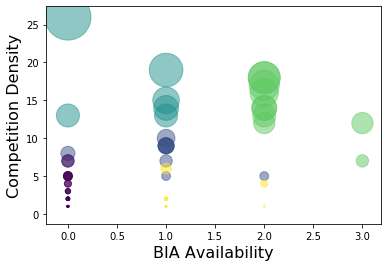

In [111]:
import matplotlib.pyplot as plt

X = nb_factors.values[:, 1:]

area = np.pi * (X[:, 1].astype(int)) ** 2
plt.scatter(X[:, 0], X[:, 1], s = area, c = labels, alpha = 0.5)
plt.xlabel('BIA Availability', fontsize = 16)
plt.ylabel('Competition Density', fontsize = 16)

plt.show()

## Results <a name="results"></a>

### Insights from Cluster Characteristics

Below are views of the members of each cluster from our K-Means analysis (clusters 0 to 4 from k = 5). Above each view is the *mean BIA/Comp ratio for the cluster*, which provides us a means of comparison between the 5 clusters upon which to make a relative decision as to the most viable location for a new coffee-related business. As a reference, the *higher* the BIA/Comp ratio, the *better* the neighbourhood for a business location relative to the metrics being used. The standard deviation of the cluster is also determined to show further characteristics of the cluster members.

#### Cluster 0

In [112]:
print('Mean BIA/Comp Ratio for Cluster {} is {}'.format(0, nb_factors.loc[neighbourhoods_bia['Cluster'] == 0]['BIA/Comp Ratio'].mean()))
print('Std Deviation of BIA/Comp Ratio for Cluster {} is {}'.format(0, nb_factors.loc[neighbourhoods_bia['Cluster'] == 0]['BIA/Comp Ratio'].std()))
nb_factors.loc[neighbourhoods_bia['Cluster'] == 0]

Mean BIA/Comp Ratio for Cluster 0 is 0.0
Std Deviation of BIA/Comp Ratio for Cluster 0 is 0.0


,Neighbourhood,Available BIAs,Competition Density,BIA/Comp Ratio
2,"Agincourt North, L'Amoreaux East, Milliken, St...",0,1,0.0
3,"Albion Gardens, Beaumond Heights, Humbergate, ...",0,1,0.0
4,"Alderwood, Long Branch",0,0,0.0
5,"Bathurst Manor, Downsview North, Wilson Heights",0,2,0.0
6,Bayview Village,0,1,0.0
7,"Bedford Park, Lawrence Manor East",0,3,0.0
9,"Birch Cliff, Cliffside West",0,1,0.0
10,"Bloordale Gardens, Eringate, Markland Wood, Ol...",0,1,0.0
12,Business Reply Mail Processing Centre 969 Eastern,0,0,0.0
14,"CN Tower, Bathurst Quay, Island airport, Harbo...",0,0,0.0


#### Cluster 1

In [113]:
print('Mean BIA/Comp Ratio for Cluster {} is {}'.format(1, nb_factors.loc[neighbourhoods_bia['Cluster'] == 1]['BIA/Comp Ratio'].mean()))
print('Std Deviation of BIA/Comp Ratio for Cluster {} is {}'.format(1, nb_factors.loc[neighbourhoods_bia['Cluster'] == 1]['BIA/Comp Ratio'].std()))
nb_factors.loc[neighbourhoods_bia['Cluster'] == 1]

Mean BIA/Comp Ratio for Cluster 1 is 0.12873015873015875
Std Deviation of BIA/Comp Ratio for Cluster 1 is 0.11258396454191189


,Neighbourhood,Available BIAs,Competition Density,BIA/Comp Ratio
11,"Brockton, Exhibition Place, Parkdale Village",1,9,0.111111
15,"Cabbagetown, St. James Town",1,9,0.111111
21,Christie,1,5,0.200000
28,Davisville,1,9,0.111111
30,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",1,9,0.111111
41,East Toronto,0,8,0.000000
52,"High Park, The Junction South",1,7,0.142857
65,"Little Portugal, Trinity",2,5,0.400000
69,Northwest,0,7,0.000000
78,"Ryerson, Garden District",1,10,0.100000


#### Cluster 2

In [114]:
print('Mean BIA/Comp Ratio for Cluster {} is {}'.format(2, nb_factors.loc[neighbourhoods_bia['Cluster'] == 2]['BIA/Comp Ratio'].mean()))
print('Std Deviation of BIA/Comp Ratio for Cluster {} is {}'.format(2, nb_factors.loc[neighbourhoods_bia['Cluster'] == 2]['BIA/Comp Ratio'].std()))
nb_factors.loc[neighbourhoods_bia['Cluster'] == 2]

Mean BIA/Comp Ratio for Cluster 2 is 0.04460831566094723
Std Deviation of BIA/Comp Ratio for Cluster 2 is 0.03548046552664549


,Neighbourhood,Available BIAs,Competition Density,BIA/Comp Ratio
19,Central Bay Street,1,13,0.076923
27,"Commerce Court, Victoria Hotel",1,19,0.052632
50,Harbourfront,1,15,0.066667
51,"Harbourfront East, Toronto Islands, Union Station",1,14,0.071429
74,Rosedale,0,26,0.000000
79,Scarborough Village,0,13,0.000000


#### Cluster 3

In [115]:
print('Mean BIA/Comp Ratio for Cluster {} is {}'.format(3, nb_factors.loc[neighbourhoods_bia['Cluster'] == 3]['BIA/Comp Ratio'].mean()))
print('Std Deviation of BIA/Comp Ratio for Cluster {} is {}'.format(3, nb_factors.loc[neighbourhoods_bia['Cluster'] == 3]['BIA/Comp Ratio'].std()))
nb_factors.loc[neighbourhoods_bia['Cluster'] == 3]

Mean BIA/Comp Ratio for Cluster 3 is 0.17496678158442866
Std Deviation of BIA/Comp Ratio for Cluster 3 is 0.09801340874469185


,Neighbourhood,Available BIAs,Competition Density,BIA/Comp Ratio
0,"Adelaide, King, Richmond",2,14,0.142857
8,Berczy Park,2,14,0.142857
20,"Chinatown, Grange Park, Kensington Market",3,7,0.428571
22,Church and Wellesley,3,12,0.250000
32,"Design Exchange, Toronto Dominion Centre",2,18,0.111111
44,"First Canadian Place, Underground city",2,17,0.117647
49,"Harbord, University of Toronto",2,13,0.153846
82,Stn A PO Boxes 25 The Esplanade,2,16,0.125000
83,Studio District,2,18,0.111111
84,"The Annex, North Midtown, Yorkville",2,12,0.166667


#### Cluster 4

In [116]:
print('Mean BIA/Comp Ratio for Cluster {} is {}'.format(4, nb_factors.loc[neighbourhoods_bia['Cluster'] == 4]['BIA/Comp Ratio'].mean()))
print('Std Deviation of BIA/Comp Ratio for Cluster {} is {}'.format(4, nb_factors.loc[neighbourhoods_bia['Cluster'] == 4]['BIA/Comp Ratio'].std()))
nb_factors.loc[neighbourhoods_bia['Cluster'] == 4]

Mean BIA/Comp Ratio for Cluster 4 is 1.0370370370370372
Std Deviation of BIA/Comp Ratio for Cluster 4 is 0.5098877088847604


,Neighbourhood,Available BIAs,Competition Density,BIA/Comp Ratio
1,Agincourt,1,0,1.000000
13,"CFB Toronto, Downsview East",1,2,0.500000
16,Caledonia-Fairbanks,1,0,1.000000
31,"Del Ray, Keelesdale, Mount Dennis, Silverthorn",1,0,1.000000
47,Glencairn,1,1,1.000000
55,"Humber Bay Shores, Mimico South, New Toronto",1,0,1.000000
58,Humewood-Cedarvale,1,0,1.000000
66,"Maryvale, Wexford",1,0,1.000000
68,North Toronto West,1,1,1.000000
70,"Northwood Park, York University",1,0,1.000000


From the individual cluster breakdown we can see that **Cluster 4** has the highest mean BIA/Comp ratio with a cluster ranking as follows:
1. Cluster 4
    * Mean BIA/Comp ratio - 1.0370370370370372
2. Cluster 3
    * Mean BIA/Comp ratio - 0.17496678158442866
3. Cluster 1
    * Mean BIA/Comp ratio - 0.12873015873015875
4. Cluster 2
    * Mean BIA/Comp ratio - 0.04460831566094723
5. Cluster 0
    * Mean BIA/Comp ratio - 0.0
    
By investigation of the cluster members its clear that Cluster 4 represents neighbourhoods with access to BIAs with minimal to no competition. Areas such as these provide the best environment in which to start a prospective coffee-related business for an aspiring entrepreneur. The locations are all within range of BIA resources and have very few competitors in the neighbourhood, Cluster 4 neighbourhoods offer the most suitable balance of BIA availability to competition density.

However, despite the clear standout in the mean BIA/Comp ratio rankings, further interpretation yields additional insights, namely in regards to Cluster 0 and Cluster 3. Despite Cluster 4 neighbourhoods providing the best all-around environment to start a new business, if a particular entrepreneur weighs factors differently, other clusters become more viable. On one hand, if BIA availability were to be desired proportionally more than competition density, Cluster 3 neighbourhoods would appear more suitable. On the other hand, if BIA availability held less significance then Cluster 0 neighbourhoods may also (in addition to Cluster 4 areas) be worth investigating further as an entrepreneur given that many locations within the cluster show minimal competition. In many ways this analysis is the first step to deciding on a new business location, establishing a foundation upon which to assess the general characteristics of Toronto neighbourhoods with different preferences and business goals.

### Toronto Neighbourhood Clustering Visualization

Another factor to consider on an intuitive basis would be the relative locations of the overall clusters to the "city's center". One could justifiably make the assertion that neighbourhoods closer to the city's center have higher population densities relative to that of neighbourhoods further inland. 

Based on the analysis and mapping performed prior we can visualize the general orientation of clusters within the city of Toronto.

In [123]:
import matplotlib.cm as cm
import matplotlib.colors as colors

toronto_map_clusters = folium.Map(location = [city_lat, city_lng], zoom_start = 11)

toronto_map_clusters.add_child(bia_locations)   

x = np.arange(k)
ys = [i + x + (i * x) ** 2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
    
for lat, lng, nhood, cluster in zip(neighbourhoods_geo['Latitude'], neighbourhoods_geo['Longitude'], neighbourhoods_bia['Neighbourhood'], neighbourhoods_bia['Cluster']):
    label = '{} - Cluster {}'.format(nhood, cluster)
    label = folium.Popup(label, parse_html = True)
    folium.CircleMarker(
        [lat, lng],
        radius = 5,
        popup = label,
        color = rainbow[cluster - 1],
        fill = True,
        fill_color = rainbow[cluster - 1],
        fill_opacity = 0.7
    ).add_to(toronto_map_clusters)

toronto_map_clusters

Through investigating the above visualization we're able to see that Cluster 4 neighbourhoods occupy a "sweet spot" in terms of their general locations relative to the denser parts of the city. Despite the inferred higher population density in the city's center, one aspect to consider is that increased population density tends to correlate with increased competition density. Its for this reason that Cluster 4 occupies a range to the city's center where it strikes a balance between still be relatively near to the BIA resources of downtown Toronto without being affected by the greater number of competitors.

Similarly, if we look at Cluster 3 neighbourhoods it is apparent that the behaviour of moderate-to-high BIA availability to higher competition density is shown as locations are exclusively in the city's center. Cluster 0 neighbourhoods are more widely dispersed and occupy the outskirts of the city, in line with the cluster characteristics of minimal BIA availability coupled with minimal competition density.

## Conclusion <a name="conclusion"></a>

The purpose of this project was to provide entrepreneurs and new business owners the ability to evaluate prospective neighbourhoods in the city of Toronto on the basis of competition and business improvement initiative availability. Foursquare and Toronto Open Data were used to consolidate neighbourhood-level competition density and BIA availability to generate a metric of how viable a particular area was to start a new business (e.g. a coffee-related business in this case). A collection of neighbourhoods with their corresponding measures were then sent through clustering analysis to establish partitions of neighbourhoods with similar characteristics. The clustering analysis yielded neighbourhood segments with relatively unique features which provided a basis for each possible business need. Regardless of the requirements of individual entrepreneurs and business owners, the project provides neighbourhood segmentation that establishes a footing for future selection of areas with varying degrees of BIA availability to competition density (e.g. Cluster 4's balanced metrics compared to Cluster 3's competition density-leaning neighbourhoods). This project provides new business owners a resource to evaluate the neighbourhoods of Toronto in way that considers the business environment, weighing both the availability of BIA initiatives and the level of industry-specific competition.